## Compare essentiality of paralogs and singletons

**Input:** Gene summary file w/ essential % and paralogy info

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats

%load_ext autoreload
%autoreload 1
from graphing_utils import *
%aimport graphing_utils

get_local_data_path = lambda folders, fname: os.path.normpath('../data/' +'/'.join(folders) +'/'+ fname)

file_gene_summary = get_local_data_path(['processed','results'], 'gene_summary_0.47.csv')

In [2]:
gene_data = pd.read_csv(file_gene_summary, index_col=0)
print('Num paralogs: %d / %d = %.3f%%' % (gene_data[gene_data.num_paralogs > 0].shape[0], gene_data.shape[0], 
                                          gene_data[gene_data.num_paralogs > 0].shape[0] / gene_data.shape[0]))
print('Num singletons: %d / %d = %.3f%%' % (gene_data[gene_data.num_paralogs == 0].shape[0], gene_data.shape[0],
                                            gene_data[gene_data.num_paralogs == 0].shape[0] / gene_data.shape[0]))

Num paralogs: 10130 / 16540 = 0.612%
Num singletons: 6410 / 16540 = 0.388%


### Are genes that are never essential enriched in paralogs?
Null hypothesis: Never essential and sometimes essential genes are equally likely to be paralogs.

In [3]:
tab = gene_data.assign(paralogy=gene_data.num_paralogs.apply(lambda x:'paralog' if x > 0 else 'singleton'), 
                       is_never_essential=gene_data.category=='Never')
ctab = pd.crosstab(tab.paralogy, tab.is_never_essential).loc[['singleton','paralog'],:]
assert(ctab.sum().sum() == tab.shape[0])
fet = stats.fisher_exact(ctab)
print('Are genes that are never essential enriched in paralogs?')
print('Fisher\'s exact test: OR=', fet[0], ', pval=', fet[1])
display(ctab)

Are genes that are never essential enriched in paralogs?
Fisher's exact test: OR= 1.7134823095494605 , pval= 8.55270797661018e-63


is_never_essential,False,True
paralogy,,
singleton,3884,2526
paralog,4791,5339


### Are genes that are ubiquitously essential enriched in singletons? 

In [4]:
tab = gene_data.assign(paralogy=gene_data.num_paralogs.apply(lambda x:'paralog' if x > 0 else 'singleton'), 
                       is_broadly_essential=gene_data.category=='Broadly')
ctab = pd.crosstab(tab.paralogy, tab.is_broadly_essential)
fet = stats.fisher_exact(ctab)
print('Are genes that are broadly essential enriched in singletons?')
print('Fisher\'s exact test: OR=', fet[0], ', pval=', fet[1])
display(ctab)

Are genes that are broadly essential enriched in singletons?
Fisher's exact test: OR= 6.105870241871608 , pval= 1.78554250129908e-149


is_broadly_essential,False,True
paralogy,,
paralog,9903,227
singleton,5623,787


### Proportion of singletons vs. paralogs in each essentiality bin

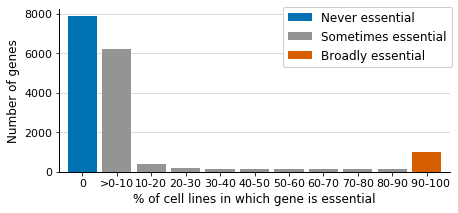

In [5]:
f, ax = plt.subplots(1, 1, figsize=(7, 3))

bins = [0, 0.000001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]
labels = ['0', '>0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '  90-100']
essential_bins = pd.cut(gene_data.essential_percent, bins=bins, labels=labels, include_lowest=True, right=False)
df = gene_data.assign(essential_bin = essential_bins,
                      is_paralog = gene_data.num_paralogs.apply(lambda x: 'Paralog' if x > 0 else 'Singleton'))
counts = pd.DataFrame(df.essential_bin.value_counts()).sort_index()
counts['color'] = ['Never'] + ['Sometimes' for i in range(0, counts.shape[0]-2)] + ['Broadly']
counts = counts.pivot(columns='color').loc[:,'essential_bin'][['Never', 'Sometimes', 'Broadly']]

# 1/ Draw distribution of essentiality categories
counts.plot.bar(stacked=True, ax=ax, rot=0, width=0.85, color=get_color_palette(1))
ax.grid(axis='y')
ax.set_ylabel('Number of genes')
ax.set_xlabel('% of cell lines in which gene is essential')
ax.legend(labels=['Never essential', 'Sometimes essential', 'Broadly essential'], title='', loc='upper right', 
          framealpha=1, bbox_to_anchor=(1.02,1.05))
#plt.savefig('../figures/fig_2A.svg', bbox_inches='tight', dpi=300)

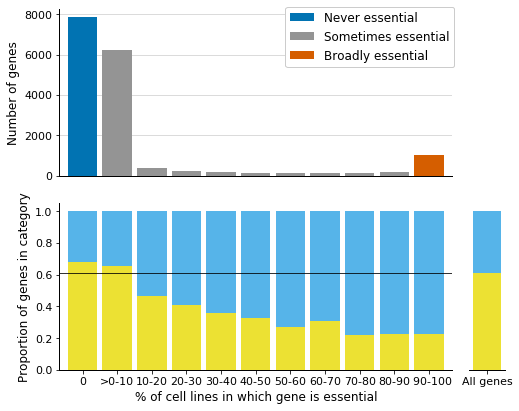

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(7.1, 5.6))
gs = fig.add_gridspec(2, 7, hspace=0)
ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])
with mpl.rc_context({'axes.spines.left':False}):
    ax3 = fig.add_subplot(gs[1, -1])

# 1/ Draw distribution of essentiality categories
counts.plot.bar(stacked=True, ax=ax1, rot=0, width=0.85, color=get_color_palette(1))
ax1.grid(axis='y'); ax1.set_xticks([])
ax1.set_ylabel('Number of genes')
ax1.legend(labels=['Never essential', 'Sometimes essential', 'Broadly essential'], title='', loc='upper right', 
           framealpha=1, bbox_to_anchor=(1.02,1.05))

# 2/ Draw paralog vs. singleton for essentiality %, with line for overall proportion
tab = pd.crosstab(df.is_paralog, df.essential_bin, dropna=False)
overall = pd.DataFrame(tab.apply(lambda x: sum(x.values)/tab.sum().sum(), axis=1), columns=['proportion'])
tab = tab.apply(lambda x: x/sum(x.values))
tab.T.plot.bar(stacked=True, ax=ax2, width=0.85, color=get_color_palette(2), rot=0)
ax2.axhline(overall.loc['Paralog', 'proportion'], color='black', linewidth=0.8)
ax2.set_xlabel('% of cell lines in which gene is essential')
ax2.set_ylabel('Proportion of genes in category')
ax2.legend().remove()
#ax2.legend(loc='upper right', bbox_to_anchor=(1,1), framealpha=0.8)

# 3/ Draw single bar with overall proportions
overall.T.plot.bar(stacked=True, width=1.5, ax=ax3, color=get_color_palette(2), rot=0)
ax3.legend().remove(); ax3.set_yticks([])
ax3.set_xticklabels(['All genes'], fontsize=11)

#plt.savefig('../figures/fig_2AC.svg', bbox_inches='tight', dpi=400)

In [7]:
# Numbers and percents of genes in different categories of essentiality
def print_category_count_and_percent(gene_data, category):
    print('%s essential: %d = %.2f%%' % (category, gene_data[gene_data.category==category].shape[0],
                                         gene_data[gene_data.category==category].shape[0] / gene_data.shape[0] * 100))
    
print_category_count_and_percent(gene_data, "Never")
print_category_count_and_percent(gene_data, "Sometimes")
print_category_count_and_percent(gene_data, "Broadly")

print('Essential in <=1%% of cell lines: %d = %.2f%%' % (gene_data[gene_data.essential_percent <= 0.01].shape[0],
                                        gene_data[gene_data.essential_percent <= 0.01].shape[0] / gene_data.shape[0] * 100))
print('Essential in >=50%% of cell lines: %d = %.2f%% ' % (gene_data[gene_data.essential_percent >= 0.5].shape[0],
                                        gene_data[gene_data.essential_percent >= 0.5].shape[0] / gene_data.shape[0] * 100))

Never essential: 7865 = 47.55%
Sometimes essential: 7661 = 46.32%
Broadly essential: 1014 = 6.13%
Essential in <=1% of cell lines: 11961 = 72.32%
Essential in >=50% of cell lines: 1559 = 9.43% 


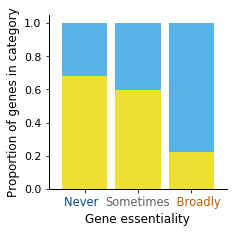

In [8]:
def color_tick_labels(ax):
    clr = get_color_palette(1)
    ax.get_xticklabels()[0].set_color((clr[0][0], clr[0][1]-0.15, clr[0][2]-0.15))
    ax.get_xticklabels()[1].set_color((clr[1][0]-0.2, clr[1][1]-0.2, clr[1][2]-0.2))
    ax.get_xticklabels()[2].set_color((clr[2][0]-0.1, clr[2][1], clr[2][2]))
    ax.set_xticklabels(['Never  ', 'Sometimes', '    Broadly'], fontsize=mpl.rcParams['axes.labelsize']-0.5)
    
f, ax = plt.subplots(1, 1, figsize=(3.2, 3.2))
df = gene_data.assign(is_paralog = gene_data.num_paralogs.apply(lambda x: 'Paralog' if x > 0 else 'Singleton'))
tab = pd.crosstab(df.is_paralog, df.category)[['Never', 'Sometimes', 'Broadly']]
tab = tab.apply(lambda x: x/sum(x.values))
tab.T.plot.bar(stacked=True, ax=ax, rot=0, width=0.85, color=get_color_palette(2))
ax.set_xlabel('Gene essentiality')
ax.set_ylabel('Proportion of genes in category')
ax.legend().remove()
color_tick_labels(ax)

#plt.savefig('../figures/fig_2B.svg', bbox_inches='tight', dpi=600)

### Number of paralogs vs. essentiality

Mann-U never vs. sometimes: 3.199682557959505e-38
Mann-U sometimes vs. broadly: 4.14397697535104e-115


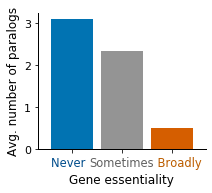

In [9]:
# Graph mean number of paralogs for each essentiality category
f, ax = plt.subplots(1, 1, figsize=(3,2.5))
n_paralogs = gene_data.groupby('category').num_paralogs.mean()
n_paralogs[['Never','Sometimes','Broadly']].plot.bar(ax=ax, rot=0, color=get_color_palette(1), width=0.85)
ax.set_ylabel('Avg. number of paralogs')
ax.set_xlabel('Gene essentiality')
color_tick_labels(ax)
#plt.savefig('avg_paralogs.svg', bbox_inches='tight')

print('Mann-U never vs. sometimes:', stats.mannwhitneyu(gene_data[gene_data.category=='Never'].num_paralogs, 
                                                        gene_data[gene_data.category=='Sometimes'].num_paralogs)[1])
print('Mann-U sometimes vs. broadly:', stats.mannwhitneyu(gene_data[gene_data.category=='Sometimes'].num_paralogs, 
                                                          gene_data[gene_data.category=='Broadly'].num_paralogs)[1])

Chi-squared test p-value: 2.686470068954178e-188


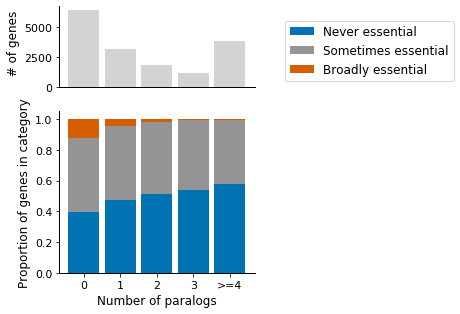

In [25]:
# Graph proportion of genes with given numbers of paralogs that are in each of 3 essentiality categories
bins = [0, 1, 2, 3, 4, max(gene_data.num_paralogs)+1]
labels = ['0', '1', '2', '3', '>=4']
paralog_bins = pd.cut(gene_data.num_paralogs, bins=bins, labels=labels, include_lowest=True, right=False)
df = gene_data.assign(paralog_bin = paralog_bins)
tab = pd.crosstab(df.paralog_bin, df.category, dropna=False)[['Never', 'Sometimes', 'Broadly']]
print('Chi-squared test p-value: ' + str(stats.chi2_contingency(tab)[1]))
counts = pd.DataFrame(tab.apply(lambda x: sum(x), axis=1), columns=['counts'])
tab = tab.apply(lambda x: x/sum(x), axis=1)
tab.columns = ['Never essential', 'Sometimes essential', 'Broadly essential']

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.5, 4.9), gridspec_kw={'height_ratios': [1, 2]})
# 1/ top plot - distribution
counts.plot.bar(stacked=True, ax=ax1, rot=0, width=0.85, color=['lightgray'])
ax1.legend().remove(); ax1.set_xticks([]); ax1.set_xlabel('')
ax1.set_ylabel('  # of genes')
# 2/ bottom plot - proportion of essentiality categories
tab.plot.bar(stacked=True, ax=ax2, rot=0, width=0.85, color=get_color_palette(1))
ax2.set_xlabel('Number of paralogs')
ax2.set_ylabel('Proportion of genes in category')
#ax2.legend().remove()
ax2.legend(loc='upper right', bbox_to_anchor=(2.05,1.6))

#plt.savefig('../figures/fig_3AB.svg', bbox_inches='tight', dpi=300)

In [15]:
# Bottom figure only (Fig 3B), for use in supplemental figures
# f, ax = plt.subplots(1, 1, figsize=(3.5,3.3))
# tab.plot.bar(stacked=True, ax=ax, rot=0, width=0.85, color=get_color_palette(1))
# ax.set_xlabel('Number of paralogs')
# ax.set_ylabel('Proportion of genes in category')
# ax.legend().remove()
# plt.savefig('../figures/fig_S4D.svg', bbox_inches='tight', dpi=300)

In [11]:
# Some paralog stats
paralogs = gene_data[gene_data.num_paralogs > 0]
print('Max num paralogs: ' + str(paralogs.num_paralogs.max()))
print('Genes with 1 paralog: '+ str(paralogs[paralogs.num_paralogs == 1].shape[0] / paralogs.shape[0]))
print('Genes with only 2-3 paralogs : '
      + str(paralogs[(paralogs.num_paralogs > 1) & (paralogs.num_paralogs < 4)].shape[0] / paralogs.shape[0]))
print('Genes with >=4 paralogs : ' + str(paralogs[paralogs.num_paralogs >= 4].shape[0] / paralogs.shape[0]))

Max num paralogs: 47
Genes with 1 paralog: 0.3170779861796644
Genes with only 2-3 paralogs : 0.30345508390918063
Genes with >=4 paralogs : 0.379466929911155


### Sequence identity of closest paralog vs. essentiality

Median sequence identity:
Never: 0.480159
Sometimes: 0.4742735
Broadly: 0.419048
Broadly vs. the rest Mann-U pval: 0.00436779416546406
Sometimes vs. never Mann-U pval: 0.4897500159549179


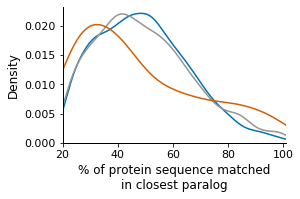

In [26]:
paralogs = gene_data[gene_data.num_paralogs > 0]
print('Median sequence identity:')
print('Never:', paralogs[paralogs.category=='Never'].percent_matched_in_paralog.median())
print('Sometimes:', paralogs[paralogs.category=='Sometimes'].percent_matched_in_paralog.median())
print('Broadly:', paralogs[paralogs.category=='Broadly'].percent_matched_in_paralog.median())

# Stats for comparing across essentiality categories
print('Broadly vs. the rest Mann-U pval:', 
      stats.mannwhitneyu(paralogs[paralogs.category=='Broadly'].percent_matched_in_paralog,
                         paralogs[paralogs.category!='Broadly'].percent_matched_in_paralog)[1])
print('Sometimes vs. never Mann-U pval:',
      stats.mannwhitneyu(paralogs[paralogs.category=='Sometimes'].percent_matched_in_paralog,
                         paralogs[paralogs.category=='Never'].percent_matched_in_paralog)[1])

# Draw sequence identity distribution for each essentiality category
f, ax = plt.subplots(1, 1, figsize=(4, 2.5))
df = paralogs.assign(percent_matched_in_paralog = paralogs.percent_matched_in_paralog * 100)
sns.kdeplot(df[df.category=='Never'].percent_matched_in_paralog, ax=ax, color=get_color_palette(1)[0])
sns.kdeplot(df[df.category=='Sometimes'].percent_matched_in_paralog, ax=ax, color=get_color_palette(1)[1])
sns.kdeplot(df[df.category=='Broadly'].percent_matched_in_paralog, ax=ax, color=get_color_palette(1)[2])
ax.set_xlim([20,101])
ax.set_xlabel('% of protein sequence matched\nin closest paralog')
ax.set_ylabel('Density')
ax.get_legend().remove()

plt.savefig('../figures/fig_3C.svg', bbox_inches='tight', dpi=300)